In [2]:
# Ad Detection Pipeline Using Fine-Tuned Sentence Transformer and Support Vector Machine (Also Before)

In [1]:
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Custom transformer to wrap a Sentence Transformer model
class SentenceTransformerVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Generate sentence embeddings
        embeddings = self.model.encode(X, batch_size=32, show_progress_bar=True)
        return embeddings

def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    # Load responses into a dictionary mapping id -> response text
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    # Load labels and merge with responses
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# File paths (update these paths as needed)
train_responses_file = '/root/Ad-Detection/Dataset/responses-train.jsonl'
train_labels_file = '/root/Ad-Detection/Dataset/responses-train-labels.jsonl'
val_responses_file   = '/root/Ad-Detection/Dataset/responses-validation.jsonl'
val_labels_file      = '/root/Ad-Detection/Dataset/responses-validation-labels.jsonl'
test_responses_file  = '/root/Ad-Detection/Dataset/responses-test.jsonl'
test_labels_file     = '/root/Ad-Detection/Dataset/responses-test-labels.jsonl'

# Load train and validation datasets separately
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)

# Combine train and validation sets into one training set
combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

# Load test dataset
test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# -----------------------------------------------------
# Experiment: Logistic Regression with Sentence Transformer Embeddings for Advertisement Detection
# Classifier: Logistic Regression (predicts label 1 as advertisement)
# Feature Extraction: Sentence Transformer to generate embeddings
# Goal: Evaluate performance specifically for detecting advertisements (label 1)
# -----------------------------------------------------

# Build the pipeline: Sentence Transformer vectorizer + Logistic Regression
pipeline = make_pipeline(
    SentenceTransformerVectorizer(model_name='all-MiniLM-L6-v2'),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

# -------------------------
# Cross-Validation on Combined Training Set
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use scoring 'f1' which, for binary classification, computes the F1 score for the positive class (label 1)
cv_scores = cross_val_score(pipeline, combined_texts, combined_labels, cv=cv, scoring='f1')
print("Cross-validation F1 Score (for ad detection, label=1) on Combined Training Set:", cv_scores)
print("Mean Cross-validation F1 Score:", np.mean(cv_scores))

# -------------------------
# Train the Model on the Full Combined Training Set
# -------------------------
pipeline.fit(combined_texts, combined_labels)

# -------------------------
# Evaluation on Combined Training Set
# -------------------------
train_preds = pipeline.predict(combined_texts)
train_report_dict = classification_report(combined_labels, train_preds, output_dict=True)
train_cm = confusion_matrix(combined_labels, train_preds)
# Save training evaluation to CSV
df_train_report = pd.DataFrame(train_report_dict).transpose()
df_train_report.to_csv('/root/Ad-Detection/csv-result/svm/train_classification_report.csv', index=True)

df_train_cm = pd.DataFrame(train_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_train_cm.to_csv('/root/Ad-Detection/csv-result/svm/train_confusion_matrix.csv', index=True)

print("\nCombined Training Set Evaluation:")
print(classification_report(combined_labels, train_preds))
print("Confusion Matrix (Combined Training):")
print(confusion_matrix(combined_labels, train_preds))
# Calculate F1 Score for label 1 explicitly:
print("F1 Score for ads (label 1):", f1_score(combined_labels, train_preds, pos_label=1))

# -------------------------
# Evaluation on Test Set
# -------------------------
test_preds = pipeline.predict(test_texts)
test_report_dict = classification_report(test_labels, test_preds, output_dict=True)
test_cm = confusion_matrix(test_labels, test_preds)

# Save test evaluation to CSV
df_test_report = pd.DataFrame(test_report_dict).transpose()
df_test_report.to_csv('/root/Ad-Detection/csv-result/svm/test_classification_report.csv', index=True)

df_test_cm = pd.DataFrame(test_cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_test_cm.to_csv('/root/Ad-Detection/csv-result/svm/test_confusion_matrix.csv', index=True)

print("\nTest Set Evaluation:")
print(classification_report(test_labels, test_preds))
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix (Test):")
print(cm)
print("F1 Score for ads (label 1):", f1_score(test_labels, test_preds, pos_label=1))

# Calculate additional metrics for label 1 based on the confusion matrix
TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall for ads
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("Detection Accuracy for ads (label 1):", detection_accuracy)
print("False Negative Rate for ads (label 1):", false_negative_rate)
print("False Positive Rate for ads (label 1):", false_positive_rate)

# Additional snippet to calculate and print the F1 score for detecting ads (label 1)
f1_ads = f1_score(test_labels, test_preds, pos_label=1)
print("F1-score for detecting ads:", f1_ads)

# Calculate additional metrics for label 0 (non-ads) by treating label 0 as the positive class
detection_accuracy_non_ads = TN / (TN + FP) if (TN + FP) > 0 else 0  # Recall for non-ads
false_negative_rate_non_ads = FP / (TN + FP) if (TN + FP) > 0 else 0
false_positive_rate_non_ads = FN / (FN + TP) if (FN + TP) > 0 else 0

print("Detection Accuracy for non-ads (label 0):", detection_accuracy_non_ads)
print("False Negative Rate for non-ads (label 0):", false_negative_rate_non_ads)
print("False Positive Rate for non-ads (label 0):", false_positive_rate_non_ads)
f1_non_ads = f1_score(test_labels, test_preds, pos_label=0)
print("F1-score for non-detecting ads (label 0):", f1_non_ads)

# -------------------------
# Submission File Generation
# -------------------------
submission_file = '/root/Ad-Detection/Submission/svm-baseline.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),  # ensuring it's an integer (0 or 1)
            "tag": "myGroupMyMethod"
        }
        f_out.write(json.dumps(result) + "\n")
        
print(f"\nSubmission file saved to: {submission_file}")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 93/93 [00:02<00:00, 40.22it/s]


Cross-validation F1 Score (for ad detection, label=1) on Combined Training Set: [0.58476027 0.59096665 0.5841714  0.58031088 0.57700651]
Mean Cross-validation F1 Score: 0.5834431437150649


Batches: 100%|██████████| 461/461 [00:11<00:00, 40.44it/s]



Combined Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      9616
           1       0.54      0.69      0.61      5128

    accuracy                           0.69     14744
   macro avg       0.67      0.69      0.68     14744
weighted avg       0.72      0.69      0.70     14744

Confusion Matrix (Combined Training):
[[6639 2977]
 [1590 3538]]
F1 Score for ads (label 1): 0.6077471442068195


Batches: 100%|██████████| 82/82 [00:02<00:00, 40.48it/s]


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1687
           1       0.52      0.63      0.57       913

    accuracy                           0.67      2600
   macro avg       0.65      0.66      0.65      2600
weighted avg       0.69      0.67      0.67      2600

Confusion Matrix (Test):
[[1168  519]
 [ 341  572]]
F1 Score for ads (label 1): 0.5708582834331337
Detection Accuracy for ads (label 1): 0.6265060240963856
False Negative Rate for ads (label 1): 0.37349397590361444
False Positive Rate for ads (label 1): 0.3076467101363367
F1-score for detecting ads: 0.5708582834331337
Detection Accuracy for non-ads (label 0): 0.6923532898636633
False Negative Rate for non-ads (label 0): 0.3076467101363367
False Positive Rate for non-ads (label 0): 0.37349397590361444
F1-score for non-detecting ads (label 0): 0.7309136420525657

Submission file saved to: /root/Ad-Detection/Submission/svm-baseline.jsonl


In [7]:
import json
import math
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ---------------------------------------
# Data Loading Function
# ---------------------------------------
def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# ---------------------------------------
# File Paths (Update these paths as needed)
# ---------------------------------------
train_responses_file = '/root/Ad-Detection/Dataset/responses-train.jsonl'
train_labels_file    = '/root/Ad-Detection/Dataset/responses-train-labels.jsonl'
val_responses_file   = '/root/Ad-Detection/Dataset/responses-validation.jsonl'
val_labels_file      = '/root/Ad-Detection/Dataset/responses-validation-labels.jsonl'
test_responses_file  = '/root/Ad-Detection/Dataset/responses-test.jsonl'
test_labels_file     = '/root/Ad-Detection/Dataset/responses-test-labels.jsonl'

# ---------------------------------------
# Load Datasets
# ---------------------------------------
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)

# Combine training and validation data
combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

# Load test dataset
test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# ---------------------------------------
# Load the Fine-Tuned Sentence Transformer Model
# ---------------------------------------
# Load your fine-tuned model from the saved path.
fine_tuned_model_path = '/root/Ad-Detection/Fine-Tune-model/fine_tuned_all-MiniLM-L6-v2'
model = SentenceTransformer(fine_tuned_model_path)

# ---------------------------------------
# Extract Embeddings
# ---------------------------------------
# Generate embeddings for the training (combined) and test texts.
train_embeddings = model.encode(combined_texts, batch_size=32, show_progress_bar=True)
test_embeddings  = model.encode(test_texts, batch_size=32, show_progress_bar=True)

# ---------------------------------------
# Train an SVM Classifier
# ---------------------------------------
# We use an SVM with a linear kernel and balanced class weights.
svm_clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(train_embeddings, combined_labels)

# ---------------------------------------
# Evaluate the Classifier on the Test Set
# ---------------------------------------
test_preds = svm_clf.predict(test_embeddings)
print("Test Set Evaluation:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))
print("F1 Score for ads (label 1):", f1_score(test_labels, test_preds, pos_label=1))

cm = confusion_matrix(test_labels, test_preds)
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0
false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("Detection Accuracy for ads (label 1):", detection_accuracy)
print("False Negative Rate for ads (label 1):", false_negative_rate)
print("False Positive Rate for ads (label 1):", false_positive_rate)

# ---------------------------------------
# Generate Submission File (Optional)
# ---------------------------------------
submission_file = '/root/Ad-Detection/Submission/baseline-SVM.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),
            "tag": "myGroupMyMethod"
        }
        f_out.write(json.dumps(result) + "\n")
print(f"\nSubmission file saved to: {submission_file}")

# ---------------------------------------
# Save Evaluation Metrics to CSV Files
# ---------------------------------------
# Create a DataFrame from the classification report
test_report_dict = classification_report(test_labels, test_preds, output_dict=True)
df_test_report = pd.DataFrame(test_report_dict).transpose()
df_test_report.to_csv('/root/Ad-Detection/csv-result/svm/fune-tuned-Results/test_classification_report.csv', index=True)

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm.to_csv('/root/Ad-Detection/csv-result/svm/fune-tuned-Results/test_confusion_matrix.csv', index=True)

print("Evaluation metrics saved to CSV files.")


Batches: 100%|██████████| 82/82 [00:01<00:00, 42.42it/s]


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1687
           1       0.97      0.96      0.97       913

    accuracy                           0.98      2600
   macro avg       0.98      0.97      0.97      2600
weighted avg       0.98      0.98      0.98      2600

Confusion Matrix:
[[1662   25]
 [  37  876]]
F1 Score for ads (label 1): 0.9658213891951488
Detection Accuracy for ads (label 1): 0.9594742606790799
False Negative Rate for ads (label 1): 0.040525739320920046
False Positive Rate for ads (label 1): 0.014819205690574985

Submission file saved to: /root/Ad-Detection/Submission/baseline-SVM.jsonl
Evaluation metrics saved to CSV files.


In [2]:
pip install "numpy<2"

  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import math
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ---------------------------------------
# Data Loading Function
# ---------------------------------------
def load_dataset(responses_file, labels_file):
    """
    Load dataset by reading responses and labels from JSONL files and merging them.
    """
    responses = {}
    with open(responses_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses[data["id"]] = data["response"]
    
    ids, texts, labels = [], [], []
    with open(labels_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            instance_id = data["id"]
            if instance_id in responses:
                ids.append(instance_id)
                texts.append(responses[instance_id])
                labels.append(data["label"])
    
    return ids, texts, labels

# ---------------------------------------
# File Paths (Update these paths as needed)
# ---------------------------------------
train_responses_file = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-train.jsonl'
train_labels_file = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-train-labels.jsonl'
val_responses_file   = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-validation.jsonl'
val_labels_file      = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-validation-labels.jsonl'
test_responses_file  = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-test.jsonl'
test_labels_file     = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/responses-test-labels.jsonl'

# ---------------------------------------
# Load Datasets
# ---------------------------------------
train_ids, train_texts, train_labels = load_dataset(train_responses_file, train_labels_file)
val_ids, val_texts, val_labels = load_dataset(val_responses_file, val_labels_file)

# Combine training and validation data for training the classifier
combined_ids = train_ids + val_ids
combined_texts = train_texts + val_texts
combined_labels = train_labels + val_labels

# Load test dataset
test_ids, test_texts, test_labels = load_dataset(test_responses_file, test_labels_file)

# ---------------------------------------
# Load the Fine-Tuned Sentence Transformer Model
# ---------------------------------------
fine_tuned_model_path = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/Advertisment-Detection/Fine-Tune-model/fine_tuned_all-MiniLM-L6-v2'
model = SentenceTransformer(fine_tuned_model_path)

# ---------------------------------------
# Extract Embeddings
# ---------------------------------------
# Generate embeddings for the combined (train + validation) and test texts.
combined_embeddings = model.encode(combined_texts, batch_size=32, show_progress_bar=True)
test_embeddings  = model.encode(test_texts, batch_size=32, show_progress_bar=True)

# ---------------------------------------
# Train an SVM Classifier
# ---------------------------------------
svm_clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_clf.fit(combined_embeddings, combined_labels)

# Determine the splitting point for training and validation sets
train_size = len(train_ids)
# Training embeddings and labels
train_embeddings = combined_embeddings[:train_size]
train_labels_split = combined_labels[:train_size]
# Validation embeddings and labels
val_embeddings = combined_embeddings[train_size:]
val_labels_split = combined_labels[train_size:]

# ---------------------------------------
# Evaluation Function
# ---------------------------------------
def evaluate_set(true_labels, embeddings, set_name="Set"):
    preds = svm_clf.predict(embeddings)
    print(f"{set_name} Evaluation:")
    print(classification_report(true_labels, preds))
    cm = confusion_matrix(true_labels, preds)
    print("Confusion Matrix:")
    print(cm)
    f1 = f1_score(true_labels, preds, pos_label=1)
    print(f"F1 Score for ads (label 1): {f1}")
    
    # Compute additional metrics
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    detection_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0
    false_negative_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
    false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
    print("Detection Accuracy for ads (label 1):", detection_accuracy)
    print("False Negative Rate for ads (label 1):", false_negative_rate)
    print("False Positive Rate for ads (label 1):", false_positive_rate)
    print("\n")
    return preds, cm, f1

# ---------------------------------------
# Evaluate on Training Set
# ---------------------------------------
train_preds, cm_train, f1_train = evaluate_set(train_labels_split, train_embeddings, set_name="Training Set")

# ---------------------------------------
# Evaluate on Validation Set
# ---------------------------------------
val_preds, cm_val, f1_val = evaluate_set(val_labels_split, val_embeddings, set_name="Validation Set")

# ---------------------------------------
# Evaluate on Test Set
# ---------------------------------------
test_preds = svm_clf.predict(test_embeddings)
print("Test Set Evaluation:")
print(classification_report(test_labels, test_preds))
cm_test = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm_test)
f1_test = f1_score(test_labels, test_preds, pos_label=1)
print("F1 Score for ads (label 1):", f1_test)
TN, FP, FN, TP = cm_test[0, 0], cm_test[0, 1], cm_test[1, 0], cm_test[1, 1]
detection_accuracy_test = TP / (TP + FN) if (TP + FN) > 0 else 0
false_negative_rate_test = FN / (TP + FN) if (TP + FN) > 0 else 0
false_positive_rate_test = FP / (FP + TN) if (FP + TN) > 0 else 0
print("Detection Accuracy for ads (label 1):", detection_accuracy_test)
print("False Negative Rate for ads (label 1):", false_negative_rate_test)
print("False Positive Rate for ads (label 1):", false_positive_rate_test)

# ---------------------------------------
# Generate Submission File (Optional)
# ---------------------------------------
submission_file = '/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/Advertisment-Detection/Submission/SentenceTransformer-SVM.jsonl'
with open(submission_file, 'w', encoding='utf-8') as f_out:
    for instance_id, pred in zip(test_ids, test_preds):
        result = {
            "id": instance_id,
            "label": int(pred),
            "tag": "SentenceTransformer-SVM"
        }
        f_out.write(json.dumps(result) + "\n")
print(f"\nSubmission file saved to: {submission_file}")

# ---------------------------------------
# Save Evaluation Metrics to CSV Files (Optional)
# ---------------------------------------
# Create a DataFrame from the classification report for the test set
test_report_dict = classification_report(test_labels, test_preds, output_dict=True)
df_test_report = pd.DataFrame(test_report_dict).transpose()
df_test_report.to_csv('/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/Advertisment-Detection/csv-results/fine-tuned-Results/test_classification_report.csv', index=True)

# Create a DataFrame for the test set confusion matrix
df_cm = pd.DataFrame(cm_test, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
df_cm.to_csv('/Users/tarekbouhairi/Desktop/Universitat Passau/Advertismenet in RAG/Ad-Detection/Advertisment-Detection/csv-results/fine-tuned-Results/test_confusion_matrix.csv', index=True)

print("Evaluation metrics saved to CSV files.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
You try to use a model that was created with version 3.4.1, however, your version is 3.3.1. This might cause unexpected behavior or errors. In that c

Training Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7541
           1       0.98      0.98      0.98      3946

    accuracy                           0.99     11487
   macro avg       0.99      0.99      0.99     11487
weighted avg       0.99      0.99      0.99     11487

Confusion Matrix:
[[7475   66]
 [  82 3864]]
F1 Score for ads (label 1): 0.9812087353986796
Detection Accuracy for ads (label 1): 0.9792194627470857
False Negative Rate for ads (label 1): 0.020780537252914344
False Positive Rate for ads (label 1): 0.008752154886619812


Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2075
           1       0.98      0.99      0.99      1182

    accuracy                           0.99      3257
   macro avg       0.99      0.99      0.99      3257
weighted avg       0.99      0.99      0.99      3257

Confusion Matrix:
[[205

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, cross_val_score

# Define the SVM classifier
clf = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Fit the classifier on your training set (if desired)
clf.fit(train_embeddings, combined_labels)

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve of an estimator.
    
    Parameters:
        estimator: scikit-learn estimator (e.g., SVC)
        X: Feature data (e.g., embeddings)
        y: Labels
        cv: Number of cross-validation folds
        scoring: Metric to evaluate
        train_sizes: Proportions of training set sizes to evaluate
    """
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="green", label="Validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="green")
    plt.title("Learning Curves")
    plt.xlabel("Number of Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot the learning curve for the SVM classifier
plot_learning_curve(clf, train_embeddings, combined_labels, cv=5, scoring='accuracy')

# Additionally, perform cross-validation to get an overall score:
cv_scores = cross_val_score(clf, train_embeddings, combined_labels, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))


ValueError: Found input variables with inconsistent numbers of samples: [11487, 14744]

(11487, 384)
(11487,)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

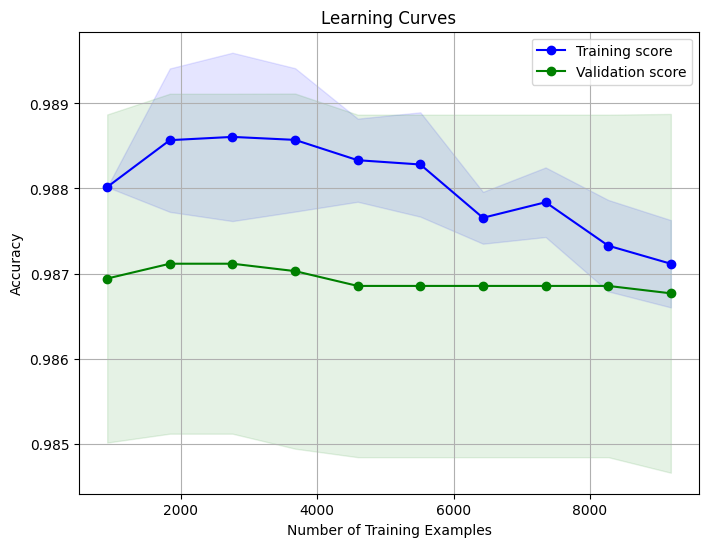

Cross-validation scores: [0.98738033 0.98955614 0.98824554 0.98432738 0.98432738]
Mean cross-validation accuracy: 0.9867673542475843


In [14]:
# Trim combined_labels to match the number of samples in train_embeddings
combined_labels = combined_labels[:11487]  # Keep only the first 11,487 labels

# Verify the shapes
print(train_embeddings.shape)  # Should print (11487, 384)
print(combined_labels.shape)   # Should print (11487,)

# Now the shapes match, so you can proceed
clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
clf.fit(train_embeddings, combined_labels)

# Plot the learning curve
plot_learning_curve(clf, train_embeddings, combined_labels, cv=5, scoring='accuracy')

# Perform cross-validation
cv_scores = cross_val_score(clf, train_embeddings, combined_labels, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

(11487, 384)
(11487,)
Training data shape: (9189, 384)
Test data shape: (2298, 384)
Training labels shape: (9189,)
Test labels shape: (2298,)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

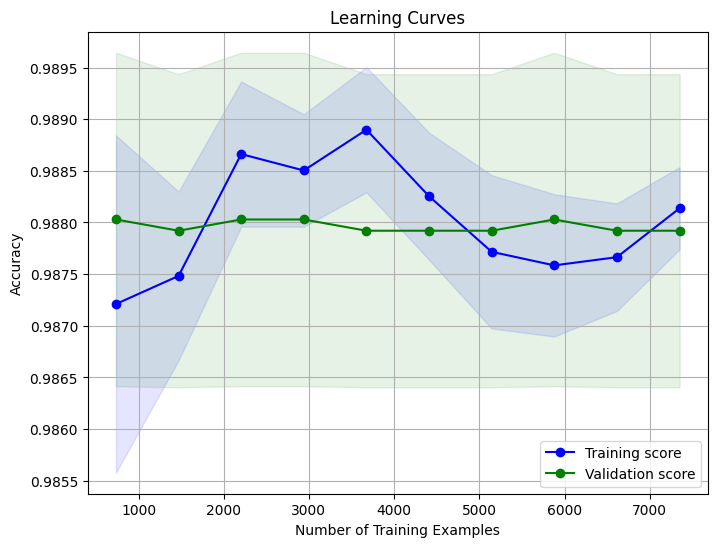

Cross-validation scores: [0.9874864  0.98966268 0.98911861 0.98531012 0.98802395]
Mean cross-validation accuracy: 0.9879203508108917
Test set accuracy: 0.9825935596170583


In [15]:
from sklearn.model_selection import train_test_split

# Trim combined_labels to match the number of samples in train_embeddings
combined_labels = combined_labels[:11487]  # Keep only the first 11,487 labels

# Verify the shapes
print(train_embeddings.shape)  # Should print (11487, 384)
print(combined_labels.shape)   # Should print (11487,)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_embeddings, combined_labels, test_size=0.2, random_state=42
)

# Verify the shapes of the training and test sets
print("Training data shape:", X_train.shape)  # Should print (9190, 384)
print("Test data shape:", X_test.shape)       # Should print (2297, 384)
print("Training labels shape:", y_train.shape)  # Should print (9190,)
print("Test labels shape:", y_test.shape)       # Should print (2297,)

# Define and train the SVM classifier on the training set
clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Plot the learning curve using the training set
plot_learning_curve(clf, X_train, y_train, cv=5, scoring='accuracy')

# Perform cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

# Evaluate the model on the test set
test_accuracy = clf.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)